# Ch.13 Bayesian statistics
The goal of a statistical analysis of a process is to figure out what are the variables that play a role and the relationships between them. Usually the observations have a random component. We might have a model of the process, for example we might start with two variables: one dependent variable y and one independent variable x. We might make two additional assumptions: the relationship between y and x is linear and the random compnent is normally distributed. The next step is to assess our assumptions using a sample of observations.

In [1]:
import math
import numpy as np
import scipy.stats as scs
import scipy.optimize as sco
from scipy import interpolate
import pymc as pm
import statsmodels.api as sm
import pandas as pd
from pylab import plt, mpl
import warnings
warnings.filterwarnings('ignore')
print('Matplotlib version: {}'.format(mpl.__version__))
print('NumPy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('PyMC version: {}'.format(pm.__version__))
print('Statsmodels version: {}'.format(sm.__version__))

Matplotlib version: 3.8.4
NumPy version: 1.26.4
Pandas version: 2.2.2
PyMC version: 5.20.1
Statsmodels version: 0.14.3


We can simulate a linear process by sampling the random component from a standard distribution with mean=0 and standard deviation std=1

$$y = a + bx + \epsilon$$

In [2]:
size = 500
x = np.linspace(0, 10, size)
y = 4 + 2 * x + np.random.standard_normal(size) * 2

Text(0, 0.5, 'y')

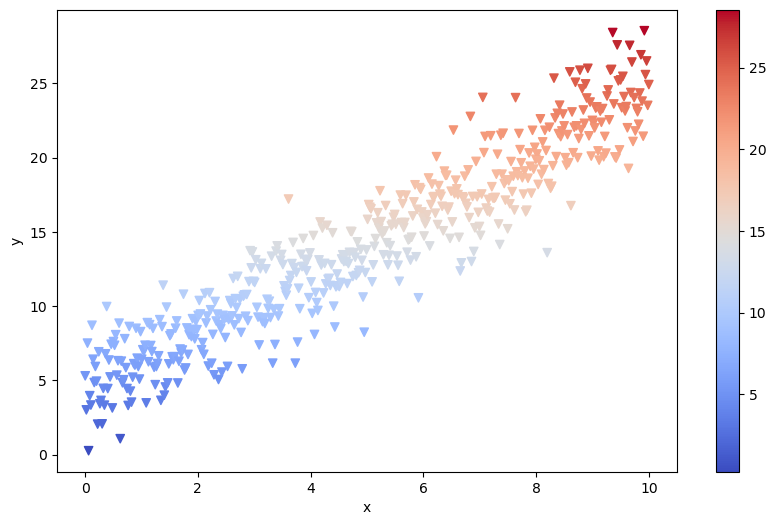

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

## Ordinary least squares
Now we can fit the simulated data using the [NumPy Polynomial.fit()](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html) method that performs a polynomial fit using the least squares method. Since we assume the relationship is linear we set the degree of the polynomial to 1. The method returns the coefficients of the polynomial.

In [4]:
from numpy.polynomial import Polynomial
reg = Polynomial.fit(x, y, deg=1)
reg

Polynomial([14.13439174,  9.93742042], domain=[ 0., 10.], window=[-1.,  1.], symbol='x')

In [5]:
a = reg.convert().coef[0]
b = reg.convert().coef[1]
print('Linear coefficients\na={:.2f}\nb={:.2f}'.format(a, b))

Linear coefficients
a=4.20
b=1.99


We plot the linear fit to the data

Text(0, 0.5, 'y')

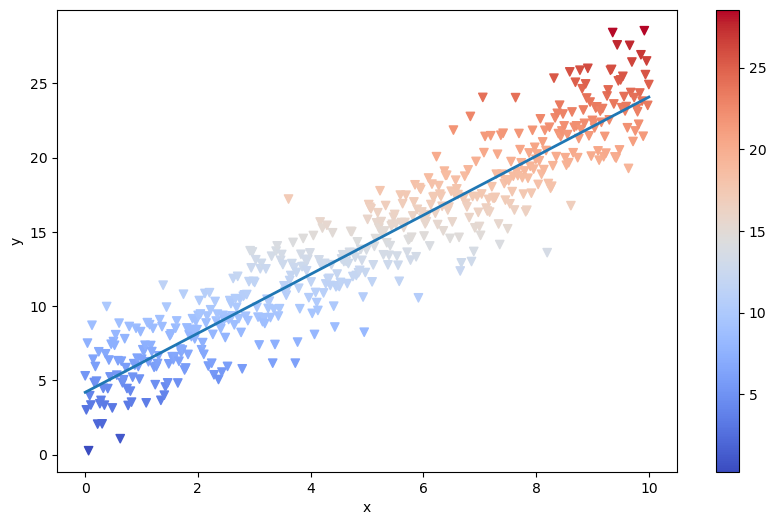

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
y_fit = a + b * x
plt.plot(x, y_fit, lw=2.0)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

## Bayes theorem
The coefficient a and b are not fixed values, they come with an associated error that can be estimated with a certain degree of confidence or accuracy. We can use the Bayesian approach to calculate the standard error of the two coefficients. Before that we discuss briefly the theory behind the Bayes theorem. Bayes' theorem is based on the multiplication theorem that can be stated as

$$P(H|D)P(D) = P(D|H)P(D)$$

so that

$$P(H|D) = \frac{P(D|H)P(H)}{P(D)}$$

where the probabilities have the following interpretation

* The hypothesis, or prior probability, P(H)
* The likelihood, or probability for the observations given the initial hypothesis, P(D|H)
* The posterivion probability, given the observations, P(H|D)
* The total probability of the observations, P(D)

In our example we assume the hypothesis that the coefficients a and b are normally distributed and independent with zero mean value and variance in [0, 20.0] and [0, 10.0] respectively, that is our prior is

$$P(H) = P(a,b) = P(a)P(b) = N(0, \sigma_a)N(0, \sigma_b)$$

For the likelihood we assume that the y(x) values are also normally distributed with mean value $\overline{y}$, calculated from the observations, and a variance $\sigma$ that we assume uniformly distributed in [0, 10.0]

$$P(D|H) = N(\overline{y}, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}}e^{\frac{1}{2}(\frac{y - \overline{y}}{\sigma})^2}$$

and

$$\sigma = U(0, 10.0)$$

We use [PyMC](https://www.pymc.io/) to build the model.

In [7]:
%%time
with pm.Model() as model:
  # model
  a = pm.Normal('a', mu=0, sigma=20)
  b = pm.Normal('b', mu=0, sigma=10)
  sigma = pm.Uniform('sigma', lower=0, upper=10)
  y_est = a + b * x
  likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y)
  # inference
  start = pm.find_MAP()
  step = pm.NUTS()
  trace = pm.sample(100, tune=1000, start=start, progressbar=True)

Output()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]


Output()

Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 41 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


CPU times: total: 20.6 s
Wall time: 2min 37s


In [8]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,4.196,0.173,3.830,4.480,0.019,0.013,84.0,132.0,1.01
b,1.988,0.031,1.930,2.051,0.003,0.002,108.0,134.0,1.00
sigma,2.055,0.057,1.946,2.142,0.005,0.005,158.0,152.0,1.00


The sampler generates a number of parallel chains with the results for the parameters depending on the number of cores available. The values in the chains can be used together by flattening the array in one single dimension.

In [9]:
trace['posterior']

<xarray.Dataset> Size: 5kB
Dimensions:  (chain: 2, draw: 100)
Coordinates:
  * chain    (chain) int32 8B 0 1
  * draw     (draw) int32 400B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
Data variables:
    a        (chain, draw) float64 2kB 4.013 4.142 4.443 ... 3.979 4.057 4.139
    b        (chain, draw) float64 2kB 2.017 1.999 1.957 ... 2.007 2.013 1.995
    sigma    (chain, draw) float64 2kB 2.067 2.052 2.051 ... 2.064 1.956 1.985
Attributes:
    created_at:                 2025-11-26T09:48:02.487915+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.20.1
    sampling_time:              41.20739221572876
    tuning_steps:               1000

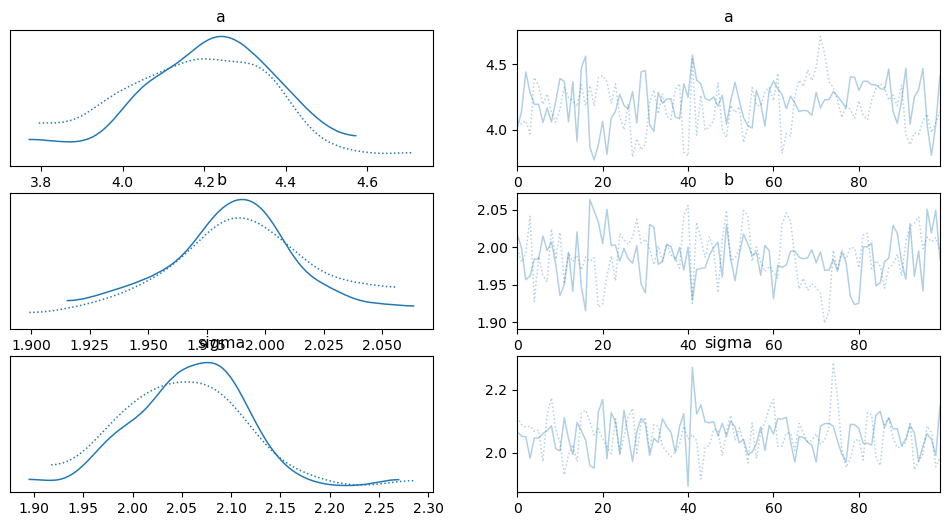

In [10]:
pm.plot_trace(trace, lines={'alpha': 4, 'beta': 2, 'sigma': 2});

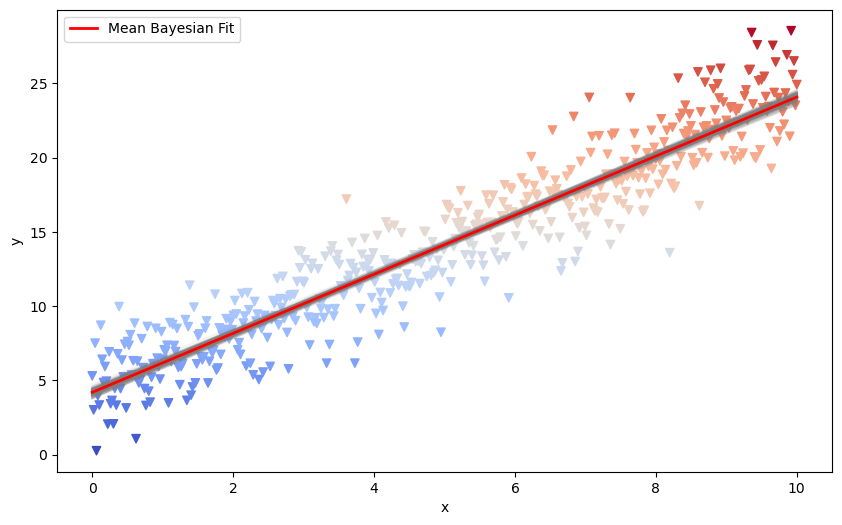

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
#plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

# Access the posterior samples for 'a' and 'b' and flatten them
a_samples = trace.posterior.a.values.flatten()
b_samples = trace.posterior.b.values.flatten()

# Iterate through each sample and plot the corresponding line
for i in range(len(a_samples)):
  y_sampled = a_samples[i] + b_samples[i] * x
  plt.plot(x, y_sampled, color='gray', alpha=0.1) # Plot with some transparency

# Optionally, plot the mean Bayesian fit
mean_a = a_samples.mean()
mean_b = b_samples.mean()
y_mean_fit = mean_a + mean_b * x
plt.plot(x, y_mean_fit, color='red', lw=2.0, label='Mean Bayesian Fit')
plt.legend()

In [57]:
raw = pd.read_csv('source/tr_eikon_eod_data.csv', index_col=0, parse_dates=True)
data = raw[['GDX', 'GLD']].dropna()
data = data / data.iloc[0]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDX     2138 non-null   float64
 1   GLD     2138 non-null   float64
dtypes: float64(2)
memory usage: 50.1 KB


In [56]:
data.corr()

,GDX,GLD
GDX,1.00000,0.71539
GLD,0.71539,1.00000


In [88]:
data.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21',
               '2018-06-22', '2018-06-25', '2018-06-26', '2018-06-27',
               '2018-06-28', '2018-06-29'],
              dtype='datetime64[ns]', name='Date', length=2138, freq=None)

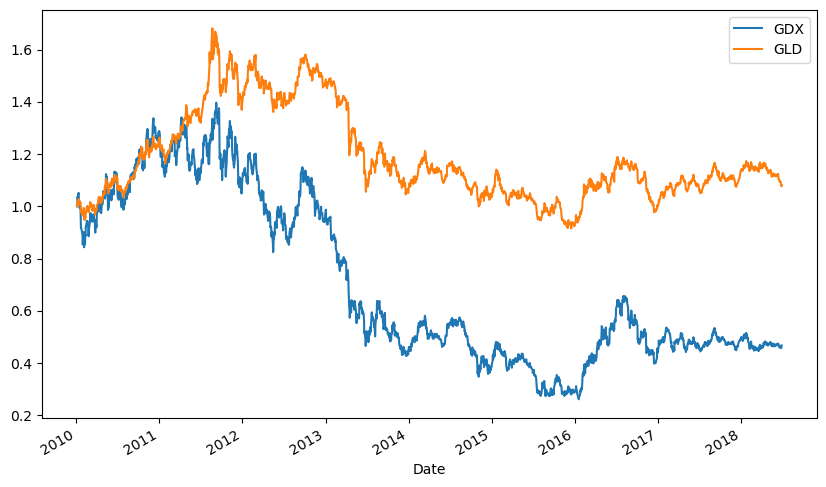

In [58]:
data.plot(figsize=(10, 6));

## Updating estimates over time

In [69]:
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())
mpl_dates[:3]

array([14613., 14614., 14615.])

In [35]:
from pymc.distributions.timeseries import GaussianRandomWalk

In [36]:
subsample_alpha = 50
subsample_beta = 50

In [43]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sig_alpha', 1. / .02, initval=.1)
    sigma_beta = pm.Exponential('sig_beta', 1. / .02, initval=.1)
    alpha = GaussianRandomWalk('alpha', sigma_alpha ** -2, shape=int(len(data) / subsample_alpha))
    beta = GaussianRandomWalk('beta', sigma_beta ** -2, shape=int(len(data) / subsample_beta))
    alpha_r = np.repeat(alpha, subsample_alpha)
    beta_r = np.repeat(beta, subsample_beta)
    regression = alpha_r + beta_r * data['GDX'].values[:2100]
    sd = pm.Uniform('sigma', 0, 20)
    likelihood = pm.Normal('GLD', mu=regression, sigma=sd, observed=data['GLD'].values[:2100])

In [47]:
with model_randomwalk:
    start = pm.find_MAP(vars=[alpha, beta])
    step = pm.NUTS()
    trace_rw = pm.sample(250, tune=1000, start=start, progressbar=True)

Output()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sig_alpha, sig_beta, alpha, beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 250 draw iterations (2_000 + 500 draws total) took 265 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [48]:
pm.summary(trace_rw).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.684,0.040,0.613,0.760,0.002,0.002,474.0,301.0,1.01
alpha[1],0.408,0.042,0.317,0.479,0.002,0.002,682.0,344.0,1.00
alpha[2],0.486,0.071,0.338,0.607,0.003,0.003,601.0,261.0,1.02
alpha[3],0.230,0.049,0.142,0.313,0.002,0.003,553.0,250.0,1.00
alpha[4],0.686,0.054,0.584,0.788,0.002,0.003,565.0,299.0,1.00


In [85]:
trace_rw['posterior']

<xarray.Dataset> Size: 349kB
Dimensions:      (chain: 2, draw: 250, alpha_dim_0: 42, beta_dim_0: 42)
Coordinates:
  * chain        (chain) int32 8B 0 1
  * draw         (draw) int32 1kB 0 1 2 3 4 5 6 ... 243 244 245 246 247 248 249
  * alpha_dim_0  (alpha_dim_0) int32 168B 0 1 2 3 4 5 6 ... 35 36 37 38 39 40 41
  * beta_dim_0   (beta_dim_0) int32 168B 0 1 2 3 4 5 6 ... 35 36 37 38 39 40 41
Data variables:
    alpha        (chain, draw, alpha_dim_0) float64 168kB 0.7412 ... 0.9987
    beta         (chain, draw, beta_dim_0) float64 168kB 0.2655 ... 0.3044
    sig_alpha    (chain, draw) float64 4kB 1.146 1.146 1.224 ... 1.116 1.092
    sig_beta     (chain, draw) float64 4kB 1.042 1.065 0.9946 ... 1.136 1.154
    sigma        (chain, draw) float64 4kB 0.016 0.01537 ... 0.01578 0.01571
Attributes:
    created_at:                 2025-11-26T14:59:39.732599+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.20.1
    sampling_time:              265.06172466278076
    tuning_steps:               1000

In [83]:
sh = np.shape(trace_rw['posterior']['alpha'])
sh

(2, 250, 42)

In [95]:
part_dates = np.linspace(min(mpl_dates), max(mpl_dates), sh[1])
part_dates[:3]

array([14613.        , 14625.44176707, 14637.88353414])

In [111]:
from datetime import date
#index = [date.fromordinal(int(date)) for date in part_dates]

In [102]:
alpha = {'alpha_%i' % i: v for i, v in enumerate(trace_rw['posterior']['alpha']) if i < 20}
alpha

{'alpha_0': <xarray.DataArray 'alpha' (draw: 250, alpha_dim_0: 42)> Size: 84kB
 array([[0.74122773, 0.33389418, 0.51132831, ..., 0.66647836, 0.77779971,
         0.88248302],
        [0.67463269, 0.31262557, 0.50741108, ..., 0.8139686 , 0.81404896,
         0.73306723],
        [0.71476918, 0.37793969, 0.57254489, ..., 0.84252637, 0.80644049,
         0.87104869],
        ...,
        [0.65819732, 0.47499713, 0.41712621, ..., 0.75885145, 0.84903086,
         1.03239523],
        [0.71913316, 0.31929236, 0.60298347, ..., 0.80651421, 0.7903175 ,
         0.87504408],
        [0.7263474 , 0.38475695, 0.41550619, ..., 0.71720541, 0.83352209,
         0.94528003]])
 Coordinates:
     chain        int32 4B 0
   * draw         (draw) int32 1kB 0 1 2 3 4 5 6 ... 243 244 245 246 247 248 249
   * alpha_dim_0  (alpha_dim_0) int32 168B 0 1 2 3 4 5 6 ... 35 36 37 38 39 40 41,
 'alpha_1': <xarray.DataArray 'alpha' (draw: 250, alpha_dim_0: 42)> Size: 84kB
 array([[0.66736002, 0.48366816, 0.33783624, 

In [106]:
df_alpha = pd.DataFrame(alpha['alpha_0'], index=data.index[:250])

In [112]:
beta = {'beta_%i' % i: v for i, v in enumerate(trace_rw['posterior']['beta']) if i < 20}
beta

{'beta_0': <xarray.DataArray 'beta' (draw: 250, beta_dim_0: 42)> Size: 84kB
 array([[0.26547519, 0.69664345, 0.54083514, ..., 0.91102706, 0.74455836,
         0.5826247 ],
        [0.33887913, 0.717843  , 0.54434726, ..., 0.61883638, 0.66940254,
         0.89513643],
        [0.29365281, 0.65191478, 0.47851487, ..., 0.55980164, 0.6817805 ,
         0.60897658],
        ...,
        [0.35302281, 0.55689438, 0.631741  , ..., 0.72269608, 0.60114394,
         0.24671854],
        [0.2858079 , 0.70999068, 0.4521418 , ..., 0.62648348, 0.71755407,
         0.58905334],
        [0.27956261, 0.6459998 , 0.63127979, ..., 0.81285386, 0.63040455,
         0.43573553]])
 Coordinates:
     chain       int32 4B 0
   * draw        (draw) int32 1kB 0 1 2 3 4 5 6 7 ... 243 244 245 246 247 248 249
   * beta_dim_0  (beta_dim_0) int32 168B 0 1 2 3 4 5 6 7 ... 35 36 37 38 39 40 41,
 'beta_1': <xarray.DataArray 'beta' (draw: 250, beta_dim_0: 42)> Size: 84kB
 array([[0.33957774, 0.54823295, 0.70620572, ..., 0

In [113]:
df_beta = pd.DataFrame(beta['beta_0'], index=data.index[:250])

<Axes: xlabel='Date'>

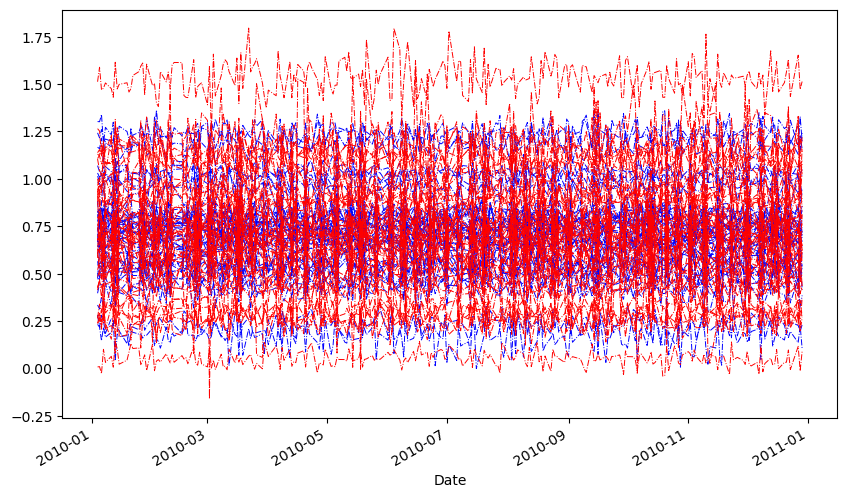

In [115]:
ax = df_alpha.plot(color='b', style='-.', legend=False, lw=0.7, figsize=(10, 6))
df_beta.plot(color='r', style='-.', legend=False, lw=0.7, ax=ax)